## Model Performance for Radar Data

All models are trained on data from fall 2016 and 2017. Hyperparameters have been tuned using 25% of the data from fall 2015.

The final model performance is evaluated on the remaining 75% of fall 2015.

Model performance is quantified using the Root Mean-Squared Error (RMSE), where only available timepoints during the night are considered.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm

In [2]:
base_dir = '/home/fiona/birdMigration/results/radar'

### Load Results

In [3]:
models = ['GAM', 'GBT', 'LocalMLP', 'LocalLSTM', 'BirdFlowGraphLSTM'] #, 'GraphLSTM']
experiments = ['', '_not_transformed', '_not_transformed', '_new', '_new', '_new']
results = dict()
bird_scales = dict()
for i, m in enumerate(models):
    if m == 'GAM':
        experiment = 'radar_specific_seasonality'
    else:
        experiment = 'best_settings' + experiments[i]
    
    # load predictions
    model_dir = osp.join(base_dir, 'testing', m, experiment)
    files = glob.glob(model_dir + "/**/results.csv", recursive = True)
    results[m] = pd.read_csv(files[0])
    
    # load bird scales
    fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
    with open(fp) as f:
        cfg = load(f, Loader=Loader)
    bird_scales[m] = cfg['datasource']['bird_scale']
    
    # load outfluxes
    if m == 'BirdFlowGraphLSTM':
        files = glob.glob(model_dir + "/**/outfluxes_abs_*.pickle", recursive = True)
        outfluxes = dict()
        for r, file in enumerate(files):
            with open(file, 'rb') as f:
                outfluxes[r] = pickle.load(f)

### Raw data

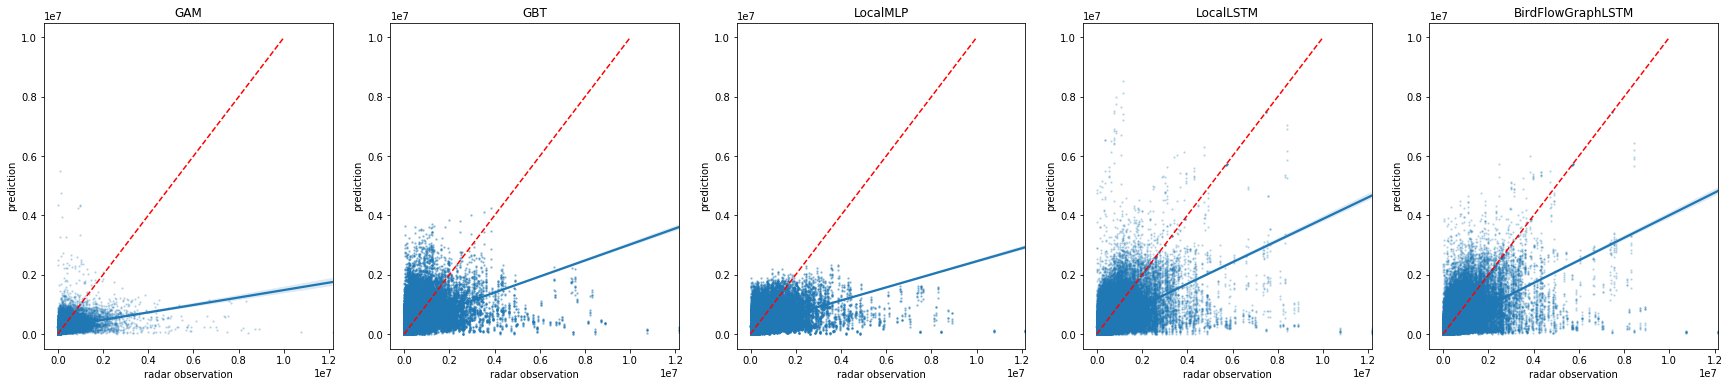

In [6]:
fig = utils.plot_results_scatter(results)

### Power-transformed data with exponent p=1/3

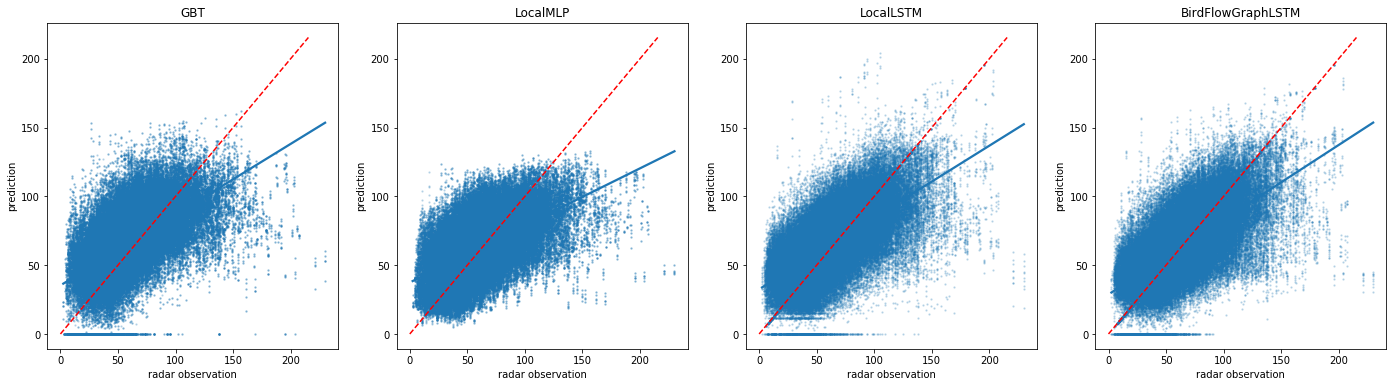

In [6]:
fig = utils.plot_results_scatter(results, root_transform=3)

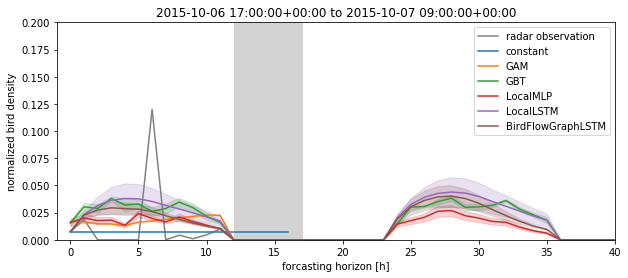

In [4]:
fig = utils.plot_example_prediction(results, 'dehnr', seqID=40, bird_scales=bird_scales, max=0.2)

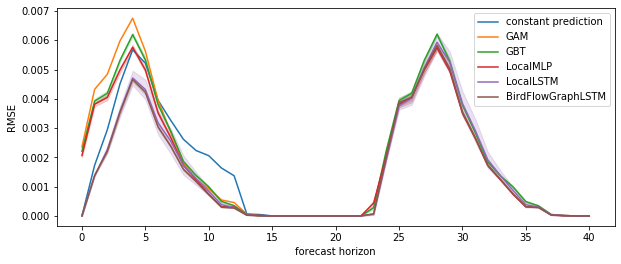

In [4]:
fig = utils.plot_errors(results, bird_scales)

## Analysis of BirdFlowGraphLSTM
### Inferred outflux per radar station
The outflux per radar station should equal to 1 at each timestep if no birds are landing and thus moving from the air to the ground.

[Text(0, 0.5, 'total outflux')]

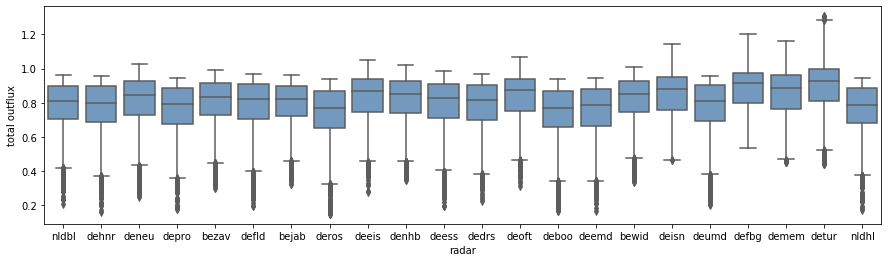

In [41]:
fig, ax = plt.subplots(figsize=(15, 4))
sb.boxplot(x='radar', y='outflux', data=results['BirdFlowGraphLSTM'].query('night == True & horizon != 0'), ax=ax, color='#6699cc') #, ci='sd')
ax.set(ylabel='total outflux')

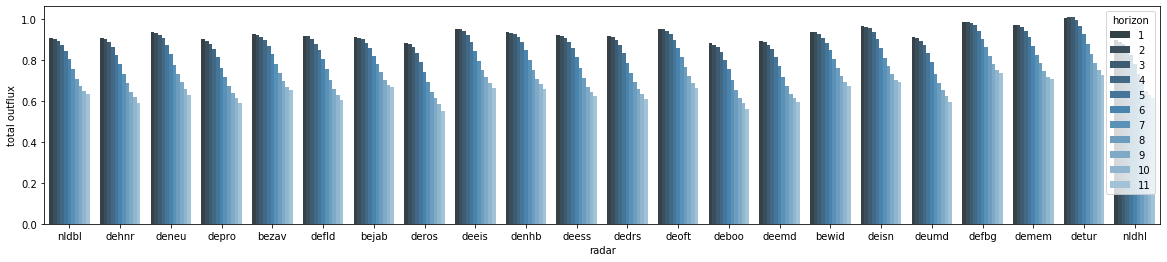

In [28]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='outflux', hue='horizon', data=results['BirdFlowGraphLSTM'].query('night == True & horizon != 0 & horizon < 12'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='total outflux');

### Inferred number of birds taking off / landing per radar station
If delta < 0, more birds are landing than taking off. Otherwise, more birds are taking off.

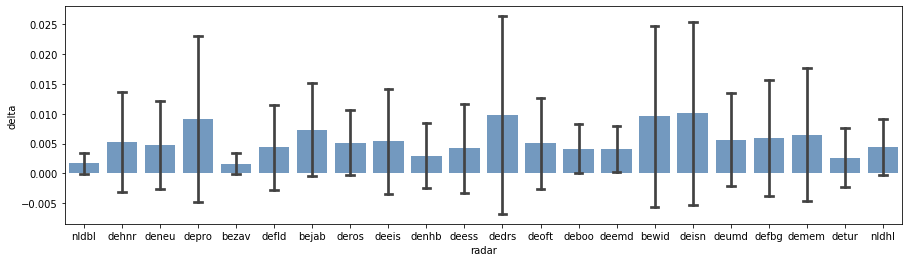

In [46]:
fig, ax = plt.subplots(figsize=(15, 4))
sb.barplot(x='radar', y='delta', data=results['BirdFlowGraphLSTM'].query('night == True & horizon != 0'), ax=ax, color='#6699cc', capsize=.2, ci='sd')

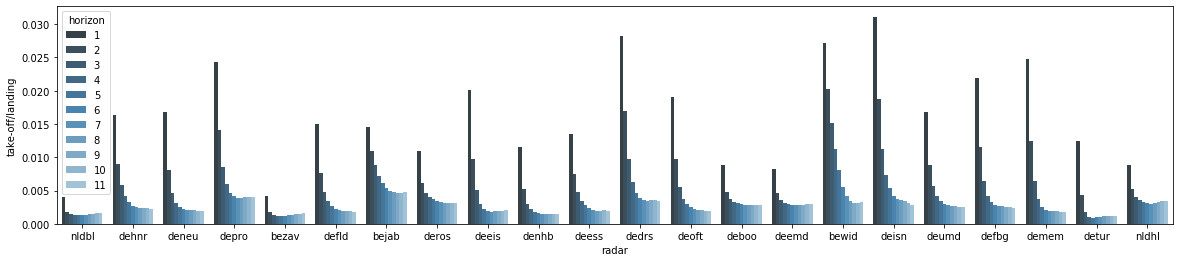

In [29]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='delta', hue='horizon', data=results['BirdFlowGraphLSTM'].query('night == True & horizon != 0 & horizon < 12'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='take-off/landing');